# InfoGAN!
![대체 텍스트](https://drive.google.com/uc?id=1_eHGgFAACgcf80S1Oi_4Qax2nPxQP6O2)

Latent 코드 $c$ 는 생성기(Generator) 입력의 일부분이며 각 분포를 나타내는 변수(continuous, categorial)를 포함하고 있다.

제너레이터가 Latent 코드 c를 사용하도록 하기 위해, 상호정보량개념(mutual information)이 GAN의 손실함수에 도입된다. 

mutual information(I)는 Y가 주어진 X의 양을 측정하거나 그 반대도 측정한다. 



The InfoGAN loss is: 




$$\min_{G} \max_{D} \, V(D, G) - \lambda I(c, G(z, c))$$




여기서 $V(D,G)$ 는 GAN의 손실함수이다. $I(c, G(z, c))$는 상호정보량(I)이다(goes in as regularization). 

목표는 데이터에 대한 의미있는 코드 c를 배우기 위해 높은 상호정보량에 도달하는 것이다. 


## TensorFlow 및 기타 라이브러리 가져오기

In [0]:
import tensorflow as tf
import numpy as np
slim = tf.contrib.slim
tfd = tf.distributions

from tensorflow.examples.tutorials.mnist import input_data

Load the MNIST dataset.

In [0]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

## InfoGAN 네트워크 생성  

![대체 텍스트](https://drive.google.com/uc?id=18msRuNcK_oXw2UReSrya0fcpRT-ZKdzZ)
  
  
*논문에 네트워크 구조가 정의되어 있음*

### Generator Network

In [0]:
# Generate images from latents.
def generator(z, out_activation_fn=tf.nn.sigmoid):
  with slim.arg_scope([slim.fully_connected, slim.conv2d_transpose],
                      normalizer_fn=slim.batch_norm):
    with slim.arg_scope([slim.conv2d_transpose], kernel_size=4, stride=2):
      net = slim.fully_connected(z, 1024)
      net = slim.fully_connected(net, 7 * 7 * 128)
      net = tf.reshape(net, [-1, 7, 7, 128])
      net = slim.conv2d_transpose(net, 64)
      net = slim.conv2d_transpose(net, 1,
                                  normalizer_fn=None,
                                  activation_fn=None)
      net = out_activation_fn(net)
      return net

### Discriminator Network

In [0]:
#Discriminate real vs. fake and predict latents from an input image.
def discriminator(x, cat_dim, cont_dim, fix_cont_std=True):
"""
  Args:
    x: Tensor of images
    cat_dim: 범주형 변수의 치수
    cont_dim: 연속 잠재 변수의 수
    fix_cont_std: 연속 잠재 변수에 대한 대략적인 posterior 의 표준 편차를 1.0으로 고정할지 여부
      
  Returns:
    q_real: 실제 vs 가짜에 대한 예측 분포
    q_cat: 범주형(discrete) 변수에 대한 예측 분포
    q_cont: 연속 변수에 대한 예측 분포  
  """
  # discriminator network
  with slim.arg_scope([slim.conv2d, slim.fully_connected],
                      activation_fn=tf.nn.leaky_relu):
    with slim.arg_scope([slim.conv2d], kernel_size=4, stride=2):
      net = slim.conv2d(x, 64, normalizer_fn=None)
      net = slim.conv2d(net, 128, normalizer_fn=slim.batch_norm)
      net = slim.flatten(net)
      net = slim.fully_connected(net, 1024, normalizer_fn=slim.batch_norm)

      # Logits for binary real vs. fake GAN discriminator
      logits_real = slim.fully_connected(net, 1, activation_fn=None)
      q_real = tfd.Bernoulli(logits=logits_real)

      # Q 출력을 위한 Recognition layer
      encoder = slim.fully_connected(net, 128, normalizer_fn=slim.batch_norm)

      # Compute logits for each category of categorical latent
      logits_cat = slim.fully_connected(encoder, cat_dim, activation_fn=None)
      q_cat = tfd.Categorical(logits=logits_cat)

      # continuous latents의 Gaussian posterior의 평균과 분산 계산
      cont_vars = slim.fully_connected(encoder, cont_dim * 2, activation_fn=None)
      cont_mu = cont_vars[:, :cont_dim]
      if fix_cont_std:
        cont_sigma = tf.ones_like(cont_mu)
      else:
        cont_sigma = tf.nn.softplus(cont_vars[:, cont_dim:])
      q_cont = tfd.Normal(loc=cont_mu, scale=cont_sigma)
      return q_real, q_cat, q_cont

## 파라메타 정의

In [0]:
# infogan 파라메타 
#  압축할 수 없는 Noise 치수(재구성되지 않음)
noise_dim = 62
#  단일 범주형 변수의 치수
cat_dim = 10
#  연속잠재 변수 수
cont_dim = 2
#  InfoGAN 정규화 term 가중치
info_reg_coeff = 1.0

# 하이퍼파라메타
#  Generator/discriminator learning rate
gen_lr = 1e-3 # 생성기 Learning rate
disc_lr = 2e-4 # 판별기 Learning rate
NB=128 # batch size

In [0]:
tf.reset_default_graph()

#압축되지 않는 noize 생성
z_noise = tfd.Uniform(low=-tf.ones([NB, noise_dim]),
                      high=tf.ones([NB, noise_dim])).sample()
#continuous code 생성
z_cont = tfd.Uniform(low=-tf.ones([NB, cont_dim]),
                     high=tf.ones([NB, cont_dim])).sample()

# 압축되지 않는 noize, discrete latent 그리고 continuous latents 동시에 발생
z = tf.concat([z_noise, z_cat_one_hot, z_cont], axis=1)

# generator 와 discriminator 네트워크 구성
with slim.arg_scope(
    [slim.fully_connected, slim.conv2d_transpose],
    weights_initializer=tf.random_normal_initializer(stddev=0.02)):
  with slim.arg_scope(
      [slim.conv2d],
      weights_initializer=tf.truncated_normal_initializer(stddev=0.02)):
    with tf.variable_scope('gnet'):
      with slim.arg_scope([slim.batch_norm], is_training=True):
        generated = generator(z)
    with tf.variable_scope('gnet', reuse=True):
      with slim.arg_scope([slim.batch_norm], is_training=False):
        generated_test = generator(z)
    with tf.variable_scope('dnet'):
      d_real, cat_real, cont_real = discriminator(images, cat_dim, cont_dim)
    with tf.variable_scope('dnet', reuse=True):
      d_fake, cat_fake, cont_fake = discriminator(generated, cat_dim, cont_dim)

Instructions for updating:
Use `tf.data.Dataset.batch(..., drop_remainder=True)`.


## objective and optimizer

In [0]:
# 일반적인 GAN의 objectives
real_labels = tf.ones([NB, 1])
fake_labels = tf.zeros([NB, 1]) 
gan_d_loss = -(tf.reduce_mean(d_real.log_prob(real_labels)) + 
               tf.reduce_mean(d_fake.log_prob(fake_labels)))
gan_g_loss = -tf.reduce_mean(d_fake.log_prob(real_labels))

# 상호정보량(I)의 Objectives
log_prob_cat = tf.reduce_sum(cat_fake.log_prob(z_cat)) / NB
log_prob_cont = tf.reduce_sum(cont_fake.log_prob(z_cont)) / NB
infogan_loss = -info_reg_coeff * (log_prob_cat + log_prob_cont)

# Generator and discriminator loss are the same as a GAN but with the added
# regularization to reconstruct a subset of latents from the image
d_loss = gan_d_loss + infogan_loss
g_loss = gan_g_loss + infogan_loss

# Optimization
global_step = tf.train.get_or_create_global_step()
dvars = tf.contrib.framework.get_variables('dnet')
gvars = tf.contrib.framework.get_variables('gnet')
gen_opt = tf.train.AdamOptimizer(gen_lr, 0.5)
disc_opt = tf.train.AdamOptimizer(disc_lr, 0.5)
train_gen_op = gen_opt.minimize(g_loss, global_step, var_list=gvars)
update_ops = (tf.get_collection(tf.GraphKeys.UPDATE_OPS))
with tf.control_dependencies(update_ops + [train_gen_op]):
  train_op = disc_opt.minimize(d_loss, global_step, var_list=dvars)

In [0]:
from IPython.display import display
import matplotlib.pyplot as plt
plt.ioff()
def display_imgs(gens):
  fig, axs = plt.subplots(1, 10, figsize=(10, 1))
  for i in range(10):
    axs.flat[i].imshow(gens[i].squeeze(), interpolation='none', cmap='gray')
    axs.flat[i].axis('off');
  return fig, axs

## Training

c:\users\tensorflow\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


0 [None, 2, -2.3242528, -2.2451491, 4.5694017, 1.4171033, 0.7046955]


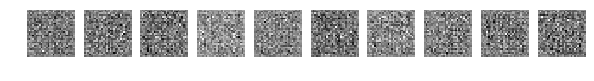

200 [None, 402, -0.20993997, -1.8634375, 2.0733776, 1.1241486, 0.87452024]


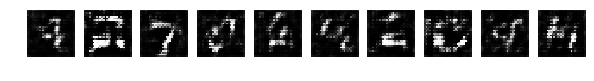

400 [None, 802, -0.07276026, -1.8675706, 1.9403309, 1.2474878, 0.8357337]


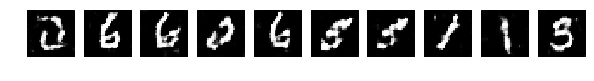

600 [None, 1202, -0.054498225, -1.8629264, 1.9174246, 1.2437154, 0.8554779]


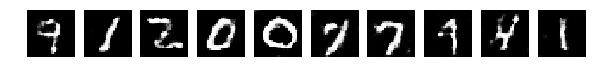

800 [None, 1602, -0.034462936, -1.8640062, 1.8984691, 1.2502755, 0.79488367]


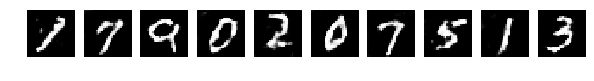

1000 [None, 2002, -0.022214243, -1.8660927, 1.888307, 1.241678, 0.81366676]


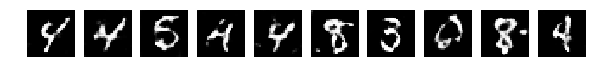

1200 [None, 2402, -0.01798242, -1.8606145, 1.8785969, 1.2645187, 0.8119335]


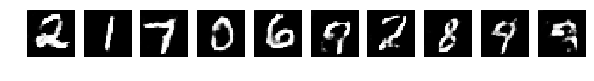

1400 [None, 2802, -0.015218335, -1.8764243, 1.8916427, 1.3151264, 0.7833234]


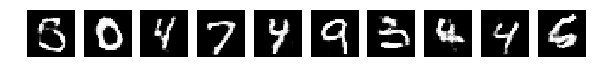

1600 [None, 3202, -0.017753292, -1.863421, 1.8811742, 1.3245505, 0.78267807]


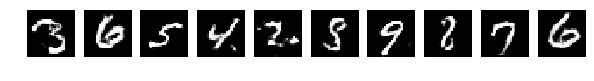

1800 [None, 3602, -0.011730204, -1.86331, 1.8750402, 1.2752322, 0.78129196]


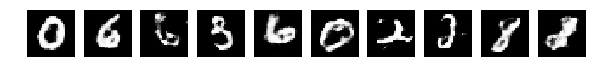

2000 [None, 4002, -0.009941101, -1.8647425, 1.8746836, 1.2588203, 0.80379987]


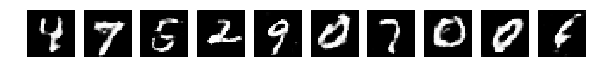

In [0]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())
steps = 2000
outs = []
for i in range(steps+1):
  out = sess.run([train_op, global_step, log_prob_cat, log_prob_cont, infogan_loss, gan_d_loss, gan_g_loss, generated])
  outs.append(out[1:-1])
  if i % (steps//10) == 0:
    print(i, out[:-1])
    fig, ax = display_imgs(out[-1])
    display(fig)
    plt.close(fig)

## Visualization

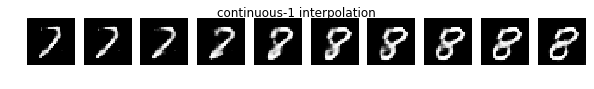

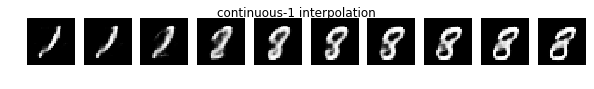

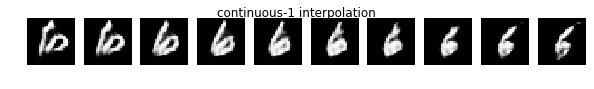

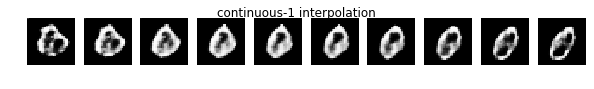

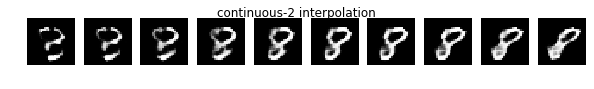

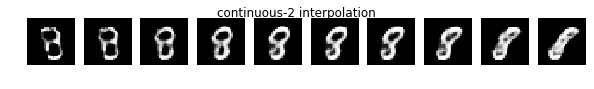

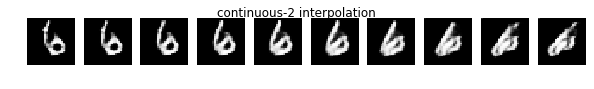

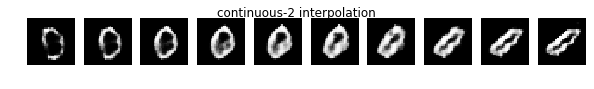

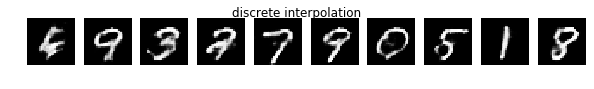

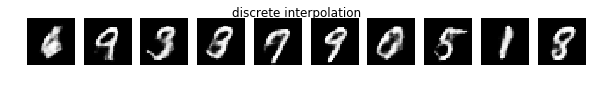

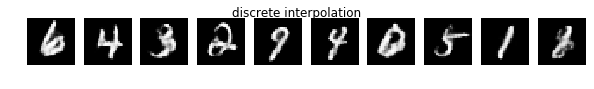

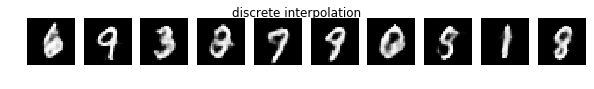

In [0]:
import numpy as np
np_z = sess.run(z)

for interp in ('continuous-1', 'continuous-2', 'discrete'):
  for i in range(4):
    z_new = np_z.copy()
    z_new[:] = z_new[i:i+1]
    if 'continuous' in interp:
      idx = int(interp.split('-')[1])
      z_new[:10, -idx] = np.linspace(-2, 2, 10)
    else:
      z_new[:cat_dim, noise_dim:noise_dim+cat_dim] = np.eye(cat_dim)
    samples = sess.run(generated_test, {z: z_new})
    display_imgs(samples);
    plt.suptitle(interp + ' interpolation')
    plt.show()

## Reference 
### 구현 저자 : Ben Poole, Kumar Krishna Agrawal  

[https://colab.research.google.com/drive/1JkCI_n2U2i6DFU8NKk3P6EkPo3ZTKAaq#scrollTo=qCa2lSXCohCX](https://colab.research.google.com/drive/1JkCI_n2U2i6DFU8NKk3P6EkPo3ZTKAaq#scrollTo=qCa2lSXCohCX)  
### 참고하기 좋은 코드:
[https://github.com/jiema58/InfoGan-Mnist/blob/master/InfoGan.ipynb](https://github.com/jiema58/InfoGan-Mnist/blob/master/InfoGan.ipynb)  
[https://github.com/openai/InfoGAN](https://github.com/openai/InfoGAN)  
### Infogan 이론 자료 :  
[1]InfoGAN 논문 [https://arxiv.org/abs/1606.03657](https://arxiv.org/abs/1606.03657)  
[2]infoGAN 이론 설명(영문) [https://towardsdatascience.com/infogan-generative-adversarial-networks-part-iii-380c0c6712cd](https://towardsdatascience.com/infogan-generative-adversarial-networks-part-iii-380c0c6712cd)   
[3]infoGAN 이론 설명(한글) [https://taeoh-kim.github.io/blog/generative-models-part-2-improvedganinfoganebgan](https://taeoh-kim.github.io/blog/generative-models-part-2-improvedganinfoganebgan)  
### 이미지자료 참고 :
[1] https://github.com/NRauschmayr/InfoGAN_Gluon/blob/master/InfoGAN.ipynb
 